In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import seaborn as sn
from lifelines.fitters.kaplan_meier_fitter import KaplanMeierFitter

pd.set_option('display.max_columns', None)


In [6]:
import utils
df_functions = [utils.get_veterans_lugn_cancer, utils.get_whas500, utils.get_aids, utils.get_gbsg2, utils.get_metabric, utils.get_flchain]

for df_func in df_functions:
    df, censorship, time = df_func(missing_values_strategy=None)
    print(f'{df_func.__name__}, total samples: {len(df)}, total features: {len(df.columns)}, percent censorships: {df[censorship].sum()/len(df)}, num samples with missing values {df.isnull().sum().sum()}')
    

get_veterans_lugn_cancer, total samples: 137, total features: 10, percent censorships: 0.9343065693430657, num samples with missing values 0
get_whas500, total samples: 500, total features: 16, percent censorships: 0.43, num samples with missing values 0
get_aids, total samples: 1151, total features: 19, percent censorships: 0.08340573414422242, num samples with missing values 0
get_gbsg2, total samples: 686, total features: 11, percent censorships: 0.4358600583090379, num samples with missing values 0
get_metabric, total samples: 2509, total features: 44, percent censorships: 0.333599043443603, num samples with missing values 2180
get_flchain, total samples: 7874, total features: 25, percent censorships: 0.27546355092710184, num samples with missing values 1350


In [3]:
df = pd.read_csv("brca_metabric/brca_metabric_clinical_data.tsv", sep="\t")
df.head()

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
0,brca_metabric,MB-0000,MB-0000,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NO,claudin-low,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Post,4ER+,Right,10.0,NaN,6.044,IDC,140.500000,0:LIVING,Negative,YES,138.65,0:Not Recurred,1,Primary,Female,ER-/HER2-,0.000000,22.0,2.0,Living
1,brca_metabric,MB-0002,MB-0002,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,NO,LumA,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,4ER+,Right,0.0,2.0,4.020,IDC,84.633333,0:LIVING,Positive,YES,83.52,0:Not Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,10.0,1.0,Living
2,brca_metabric,MB-0005,MB-0005,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,YES,Pre,3,Right,1.0,2.0,4.030,IDC,163.700000,1:DECEASED,Positive,NO,151.28,1:Recurred,1,Primary,Female,NaN,2.615035,15.0,2.0,Died of Disease
3,brca_metabric,MB-0006,MB-0006,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,YES,LumB,1.0,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,YES,Pre,9,Right,3.0,1.0,4.050,MDLC,164.933333,0:LIVING,Positive,YES,162.76,0:Not Recurred,1,Primary,Female,NaN,1.307518,25.0,2.0,Living
4,brca_metabric,MB-0008,MB-0008,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,YES,LumB,1.0,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,YES,Post,9,Right,8.0,2.0,6.080,MDLC,41.366667,1:DECEASED,Positive,YES,18.55,1:Recurred,1,Primary,Female,ER+/HER2- High Prolif,2.615035,40.0,2.0,Died of Disease


Pie Plots

C:\Users\User\AppData\Local\Temp\ipykernel_11324\1129203406.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(math.ceil(num_plots/plot_columns), plot_columns, i+1)


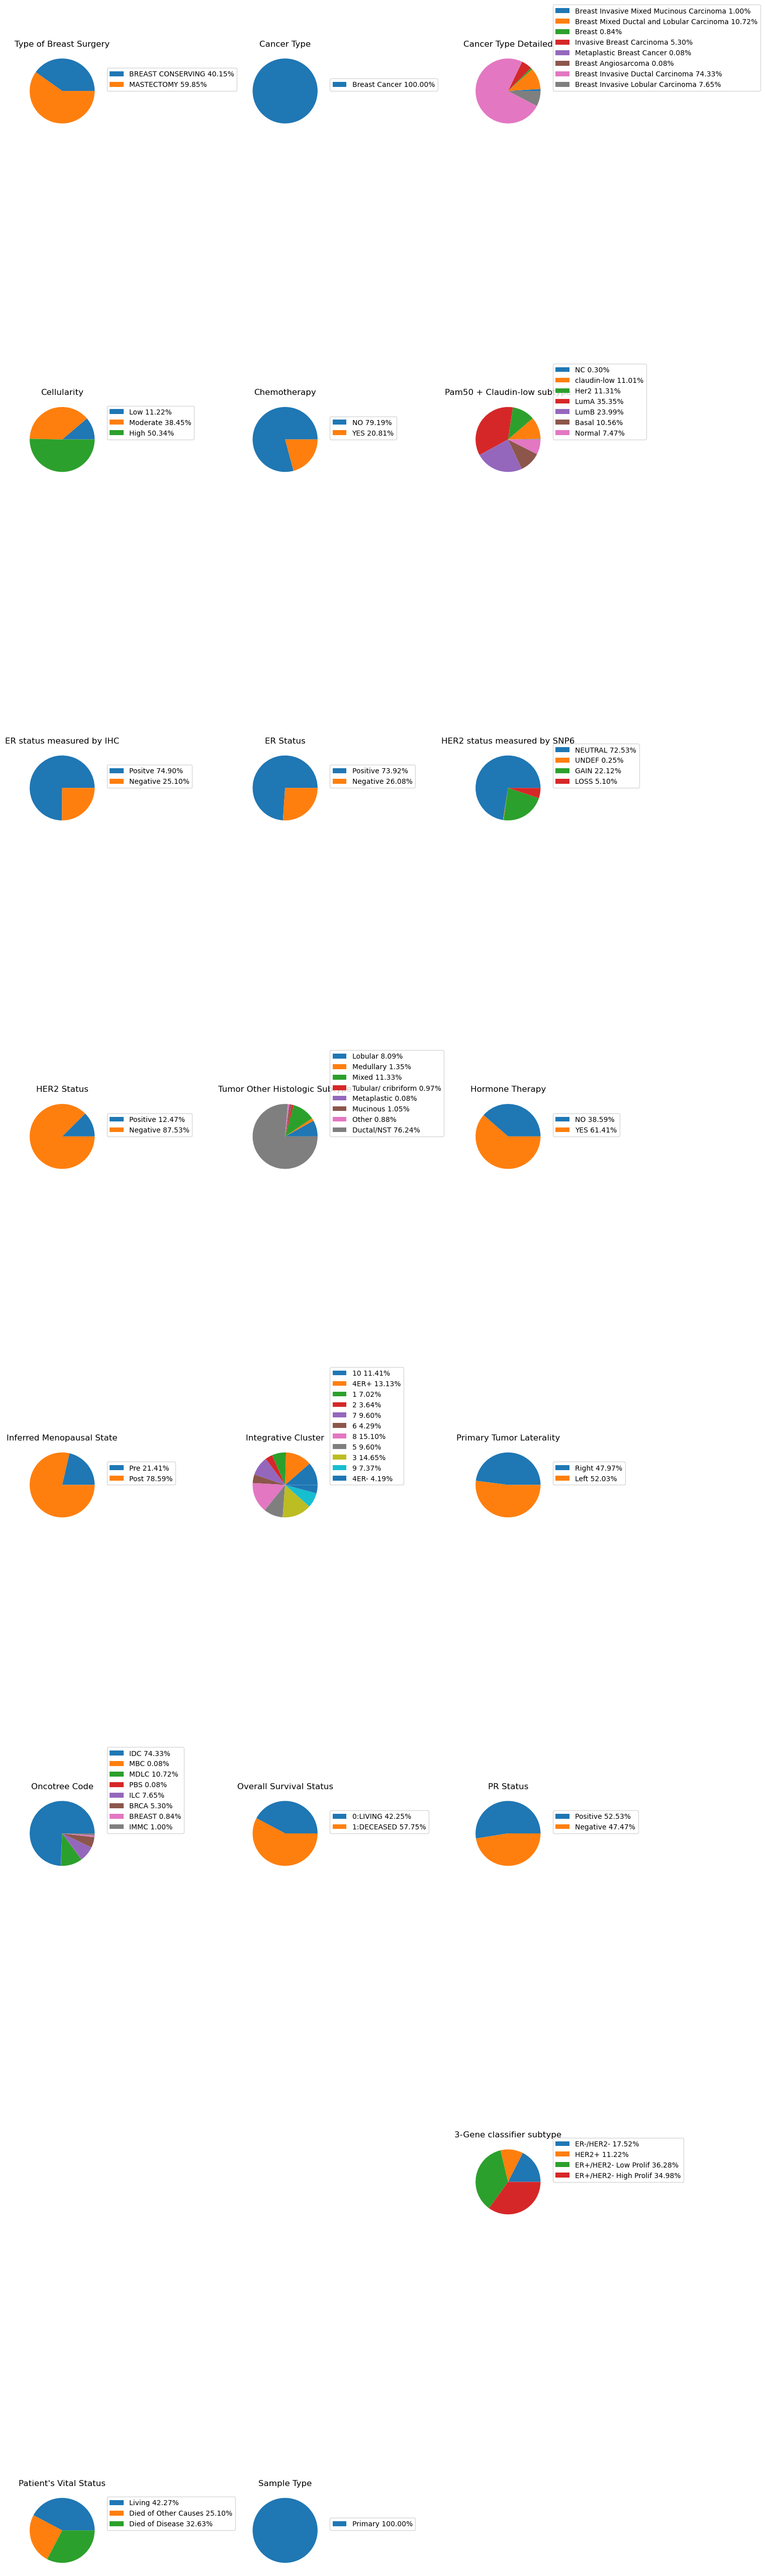

In [4]:
column_names_to_plot = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype',
                         'ER status measured by IHC', 'ER Status', 'HER2 status measured by SNP6', 'HER2 Status',
                        'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster',
                        'Primary Tumor Laterality', 'Oncotree Code', 'Overall Survival Status', 'PR Status', 'Radio Therapy',
                        'Relapse Free Status', '3-Gene classifier subtype', "Patient's Vital Status", "Sample Type"]
num_plots = len(column_names_to_plot)
plot_columns = 3

plt.figure(figsize=(15,60))
for i, column_name in enumerate(column_names_to_plot):
    column_values = df[column_name].values
    #remove nan
    column_values = np.array([x for x in column_values if str(x) != 'nan'])

    labels, counts = [], []
    for val in set(column_values):
        count = (column_values==val).sum()
        counts.append(count)
        labels.append(f'{val} {(count/len(column_values) * 100.0):1.2f}%')

    plt.subplot(math.ceil(num_plots/plot_columns), plot_columns, i+1)
    # plt.figure()
    plt.title(column_name)
    plt.pie(counts)
    plt.legend(labels=labels, loc=(1.05, 0.5))
    plt.tight_layout()
    # save plot to a file with title as name
    # os.mkdir('plots') if not os.path.exists('plots') else None
    # plt.savefig(f'plots/{column_name}.png', bbox_inches='tight')


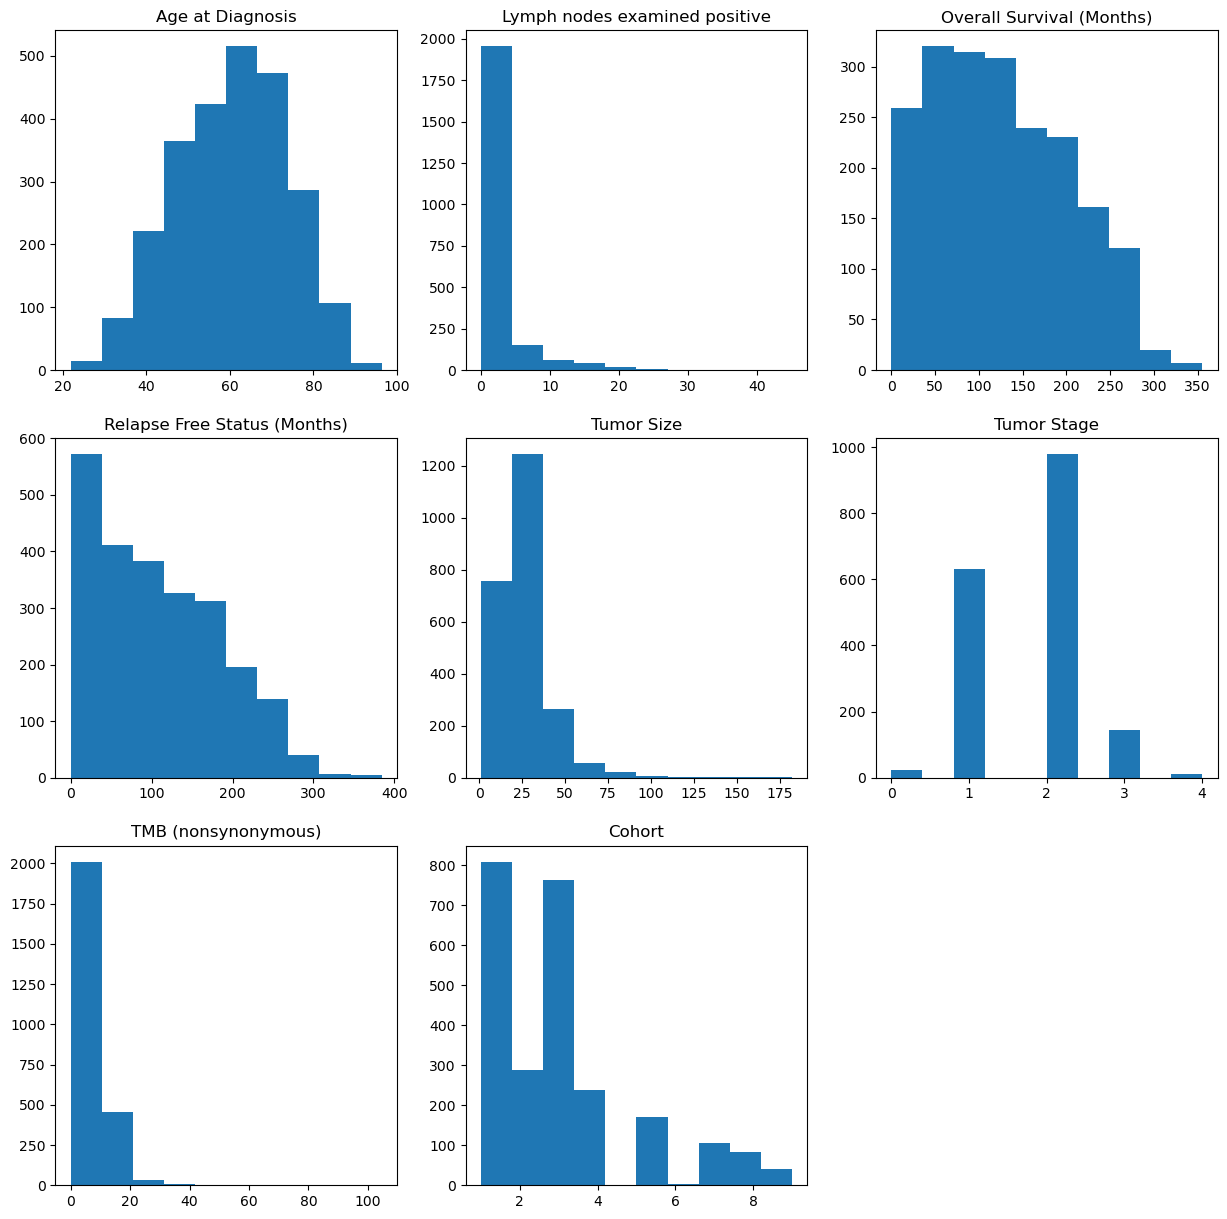

In [5]:
column_names_for_hist = ['Age at Diagnosis', 'Lymph nodes examined positive', 'Overall Survival (Months)',
                         'Relapse Free Status (Months)', 'Tumor Size', 'Tumor Stage', 'TMB (nonsynonymous)', "Cohort"]
num_plots = len(column_names_for_hist)
plot_columns = 3
plt.figure(figsize=(15,15))
for i, column_name in enumerate(column_names_for_hist):
    val = df[column_name].values
    plt.subplot(math.ceil(num_plots/plot_columns), plot_columns, i+1)
    # plt.figure()
    plt.hist(val)
    plt.title(column_name)
    # plt.savefig(f'plots/{column_name}.png')
plt.show()

In [6]:
heatmap = df.notna()
heatmap["S"] = heatmap.sum(axis=1)
heatmap = heatmap.sort_values(by="S", ascending = False)
heatmap = heatmap.drop(columns = "S")
heatmap

,Study ID,Patient ID,Sample ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,ER Status,Neoplasm Histologic Grade,HER2 status measured by SNP6,HER2 Status,Tumor Other Histologic Subtype,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Primary Tumor Laterality,Lymph nodes examined positive,Mutation Count,Nottingham prognostic index,Oncotree Code,Overall Survival (Months),Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Number of Samples Per Patient,Sample Type,Sex,3-Gene classifier subtype,TMB (nonsynonymous),Tumor Size,Tumor Stage,Patient's Vital Status
1254,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1489,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1485,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
863,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
861,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,False,True,False,True,False
2318,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,False,True,False,True,False
2144,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,False,True,False,True,False
2055,True,True,True,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,True,True,False,True,False,True,False


<AxesSubplot: >

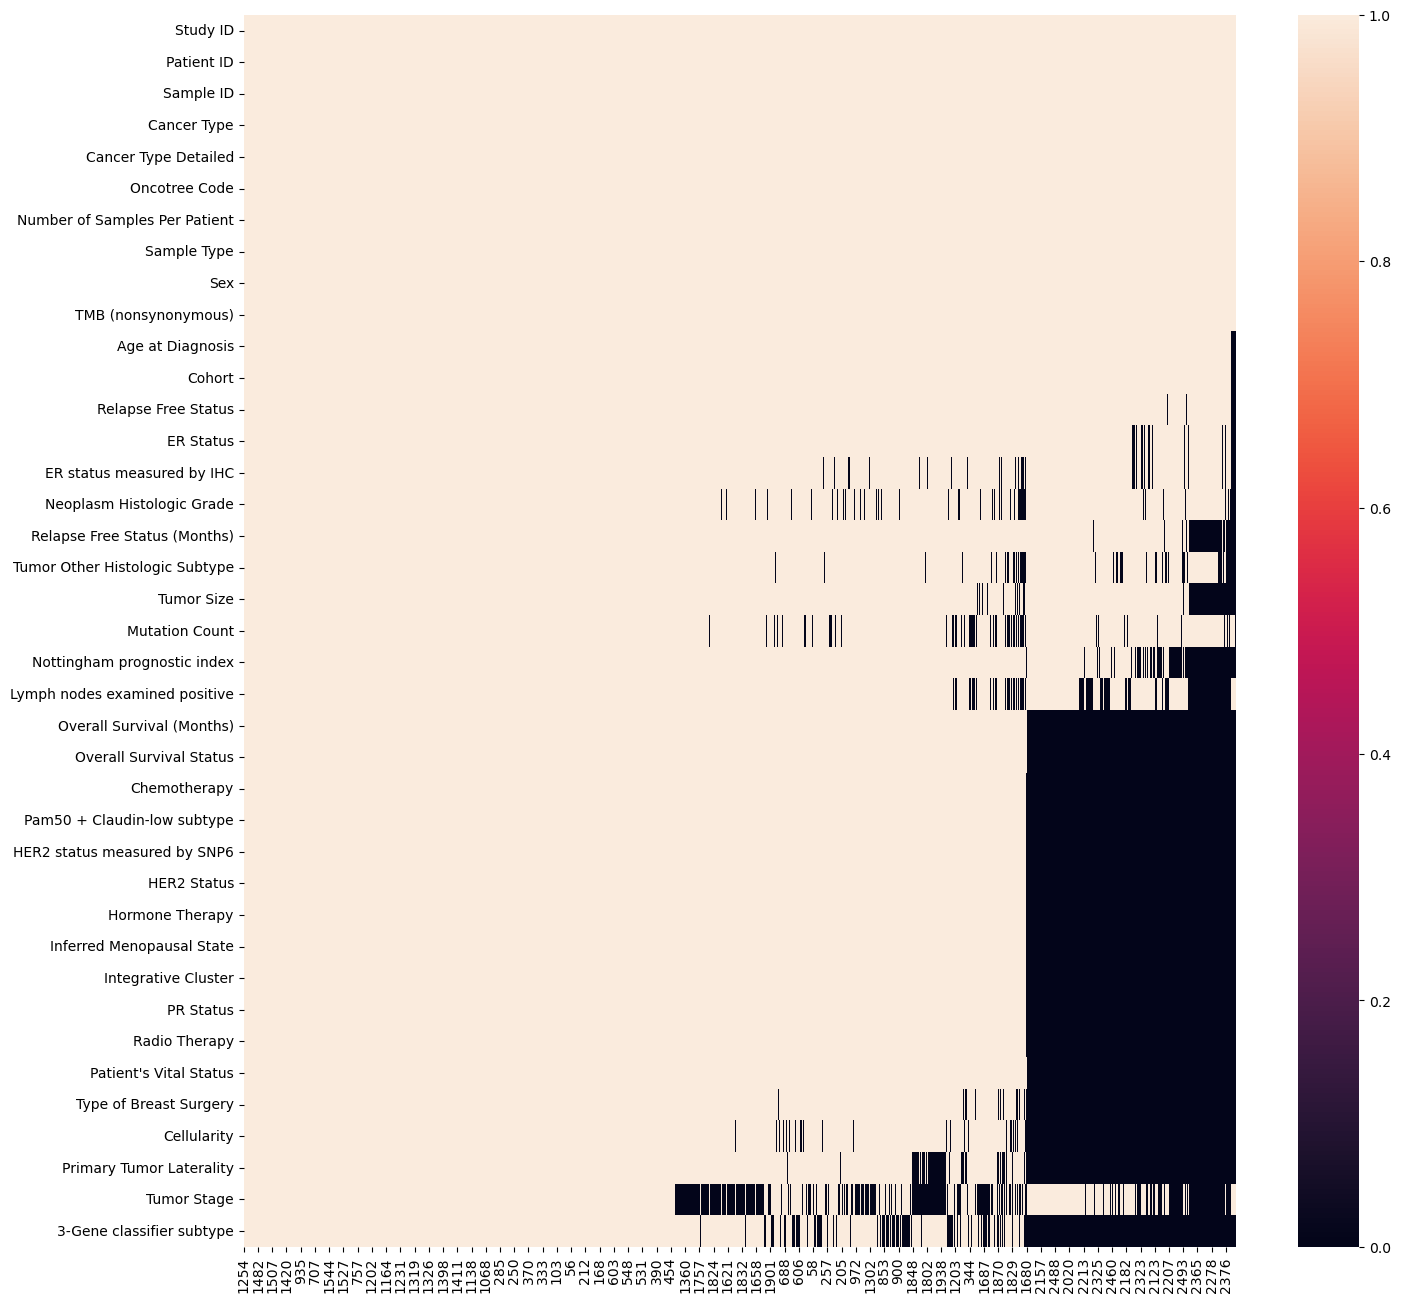

In [7]:
labels = heatmap.columns
values = [heatmap[x].sum() for x in labels]
labels, values = zip(*sorted(zip(labels, values), key=lambda x: x[1], reverse=True))
plt.figure(figsize=(16,16))
sn.heatmap(heatmap.reindex(labels, axis=1).transpose())
# plt.savefig('plots/heatmap.png')

Text(0.5, 0, 'Time (Months)')

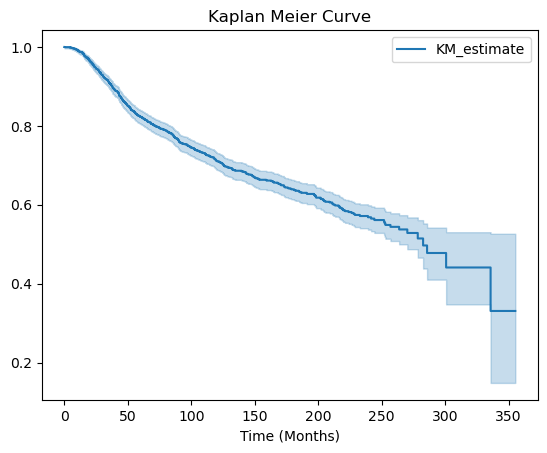

In [8]:
df_valid = df.dropna(subset=['Overall Survival (Months)', 'Patient\'s Vital Status'])
survival_times = df_valid["Overall Survival (Months)"].values
censorship = [True if x =="Died of Disease" else False for x in df_valid["Patient's Vital Status"].values]
kmf = KaplanMeierFitter()
kmf.fit(survival_times, event_observed=censorship)
plt.title("Kaplan Meier Curve")
kmf.plot()
plt.xlabel("Time (Months)")
# plt.savefig('plots/Kaplan Meier Curve.png')